In [5]:
import pandas as pd

df = pd.read_parquet("combined_sample.parquet")
df.head()


,review_date,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline_blob,review_body_blob,source_file
0,2010-10-22,b'US',30747678,b'R2DLULDLBHSKMB',b'B002DVHTFI',81224492,"b""It's A 10 miracle shine spray with noni oil ...",b'Beauty',5,40,43,False,True,b'Love this!',"b""I have already finished my first bottle (it ...",amazon_reviews_2010.snappy.parquet
1,2010-08-24,b'US',51191586,b'R354LZCZ9F7LZ2',b'B0015T963C',419585077,"b'Kindle Wireless Reading Device, Free 3G, 6"" ...",b'PC',5,0,0,False,True,b'Love my Kindle',"b""I love my Kindle and am happy with my purch...",amazon_reviews_2010.snappy.parquet
2,2010-12-13,b'US',51820340,b'R3NH6EOQIO0X82',b'B000XTJJ7I',814024329,b'Bell + Howell Brass-Tone Swivel-Arm Sunlight...,b'Health & Personal Care',1,3,3,False,True,b'Attractive but Defective',"b""My experience mirrors that of R. Pergola. Th...",amazon_reviews_2010.snappy.parquet
3,2010-08-21,b'US',13010499,b'R26BGDY4EY65C2',b'B000GB0G02',749658107,"b""Casio Men's AW80V-5BV""",b'Watches',1,5,13,False,True,b'Watch review',"b""I bought two of these watches and are going ...",amazon_reviews_2010.snappy.parquet
4,2010-11-08,b'US',33141687,b'R2EC2VJXLVDEPK',b'B0017H88XG',223422375,b'VXI BlueParrott 202524 Roadwarrior B250 Blue...,b'Wireless',5,0,0,False,True,b'Clarity at last!',b'I have been looking for a hands-free headset...,amazon_reviews_2010.snappy.parquet


In [7]:
def safe_decode(x):
    if isinstance(x, (bytes, bytearray)):
        return x.decode("utf-8", errors="replace")
    return x

df["review_headline"] = df["review_headline_blob"].apply(safe_decode)
df["review_body"] = df["review_body_blob"].apply(safe_decode)

df[["review_date", "review_headline", "review_body", "source_file"]].head()


,review_date,review_headline,review_body,source_file
0,2010-10-22,Love this!,I have already finished my first bottle (it la...,amazon_reviews_2010.snappy.parquet
1,2010-08-24,Love my Kindle,I love my Kindle and am happy with my purchas...,amazon_reviews_2010.snappy.parquet
2,2010-12-13,Attractive but Defective,My experience mirrors that of R. Pergola. The ...,amazon_reviews_2010.snappy.parquet
3,2010-08-21,Watch review,I bought two of these watches and are going to...,amazon_reviews_2010.snappy.parquet
4,2010-11-08,Clarity at last!,I have been looking for a hands-free headset w...,amazon_reviews_2010.snappy.parquet


In [12]:
#check for missing vals
df.isna().sum()


,0
review_date,0
marketplace,0
customer_id,0
review_id,0
product_id,0
product_parent,0
product_title,0
product_category,0
star_rating,0
helpful_votes,0


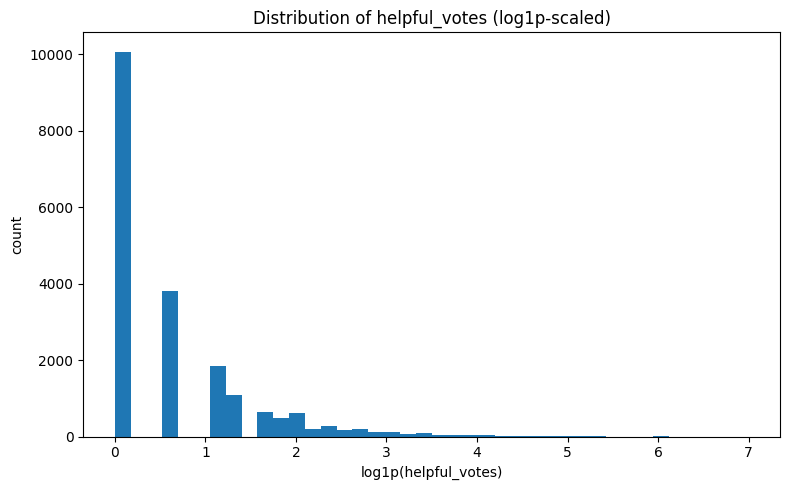

In [24]:
import numpy as np
import matplotlib.pyplot as plt

x = df_plot["helpful_votes"].dropna().astype(int)

# log1p transform / natural log
x_log = np.log1p(x)

plt.figure(figsize=(8,5))
plt.hist(x_log, bins=40)
plt.title("Distribution of helpful_votes (log1p-scaled)")
plt.xlabel("log1p(helpful_votes)")
plt.ylabel("count")
plt.tight_layout()
plt.show()


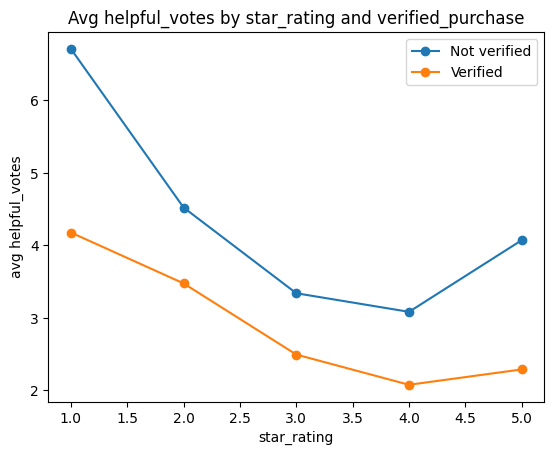

In [25]:
if "star_rating" in df.columns:
    g = (df_plot
         .dropna(subset=["star_rating"])
         .groupby(["star_rating", "verified_purchase"])["helpful_votes"]
         .mean()
         .unstack("verified_purchase"))

    plt.figure()
    x = g.index.values
    plt.plot(x, g[False].values, marker="o", label="Not verified")
    plt.plot(x, g[True].values, marker="o", label="Verified")
    plt.title("Avg helpful_votes by star_rating and verified_purchase")
    plt.xlabel("star_rating")
    plt.ylabel("avg helpful_votes")
    plt.legend()
    plt.show()


The graph above is interesting because we would expect that verified purchases are more likely to have higher average helpful votes. Looking at the graph above, this is not the case, as the orange line (verified purchase) is always below the blue line (not verfied purchase).

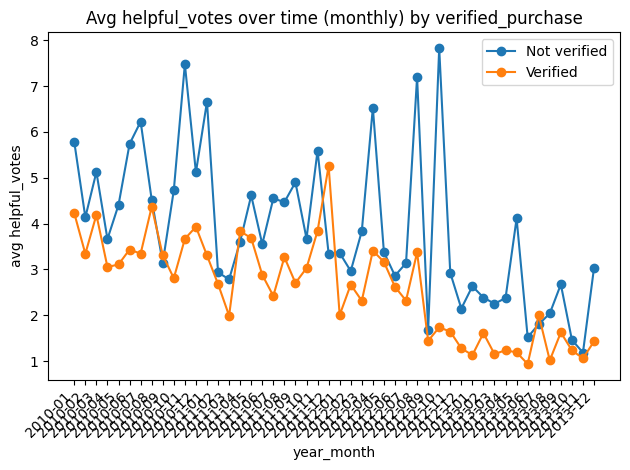

In [30]:
trend = (df_plot
         .groupby(["year_month", "verified_purchase"])["helpful_votes"]
         .mean()
         .unstack("verified_purchase")
         .sort_index())

plt.figure()
plt.plot(trend.index, trend[False], marker="o", label="Not verified")
plt.plot(trend.index, trend[True], marker="o", label="Verified")
plt.title("Avg helpful_votes over time (monthly) by verified_purchase")
plt.xlabel("year_month")
plt.ylabel("avg helpful_votes")
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.tight_layout()
plt.show()

The trend of non-verfied purchase based reviews having higher average helpful votes compared to verfied-purchase reviews is consisent as time passes.

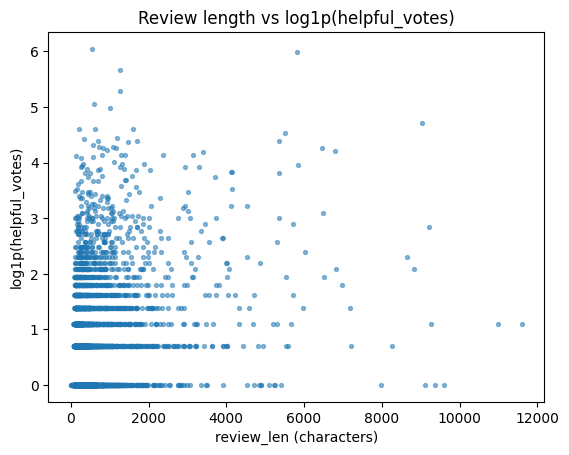

In [26]:
tmp = df_plot.sample(n=min(5000, len(df_plot)), random_state=1)

plt.figure()
plt.scatter(tmp["review_len"], tmp["helpful_log1p"], s=8, alpha=0.5)
plt.title("Review length vs log1p(helpful_votes)")
plt.xlabel("review_len (characters)")
plt.ylabel("log1p(helpful_votes)")
plt.show()


This graph tells us that most reviews get zero helpful votes, reagardless of length (as seen by the line at y = 0). As length of review increases we do see an increase of helpful votes, but it is noisy, alluding to the idea that more factors are involved.

/tmp/ipython-input-3090916819.py:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df_hm.pivot_table(


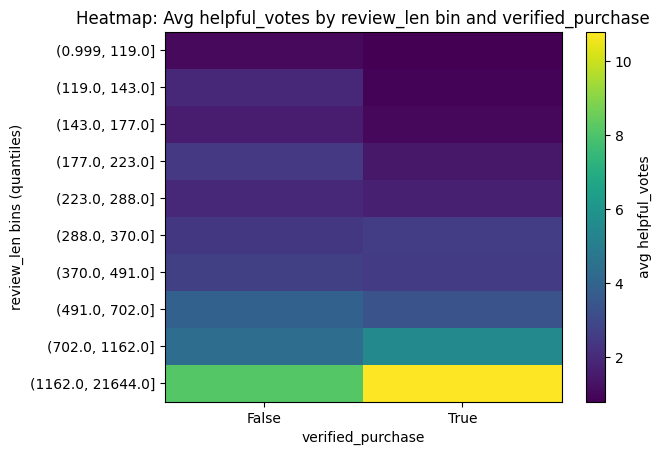

In [35]:
df_hm = df_plot.copy()
df_hm["len_bin"] = pd.qcut(df_hm["review_len"], q=10, duplicates="drop")

pivot = df_hm.pivot_table(
    index="len_bin",
    columns="verified_purchase",
    values="helpful_votes",
    aggfunc="mean"
)

plt.figure()
plt.imshow(pivot.values, aspect="auto")
plt.yticks(range(len(pivot.index)), [str(x) for x in pivot.index])
plt.xticks(range(len(pivot.columns)), [str(c) for c in pivot.columns])
plt.colorbar(label="avg helpful_votes")
plt.title("Heatmap: Avg helpful_votes by review_len bin and verified_purchase")
plt.xlabel("verified_purchase")
plt.ylabel("review_len bins (quantiles)")
plt.show()


As we look down the y axis (top to bottom), we see the colors getting lighter, meaning that as length of review increases, so does average number of helpful votes. Being a verfied purchase matters more when the review is longer, as seen by the yellow section.

/tmp/ipython-input-1694599809.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  d.groupby(["len_bin", "verified_purchase"])


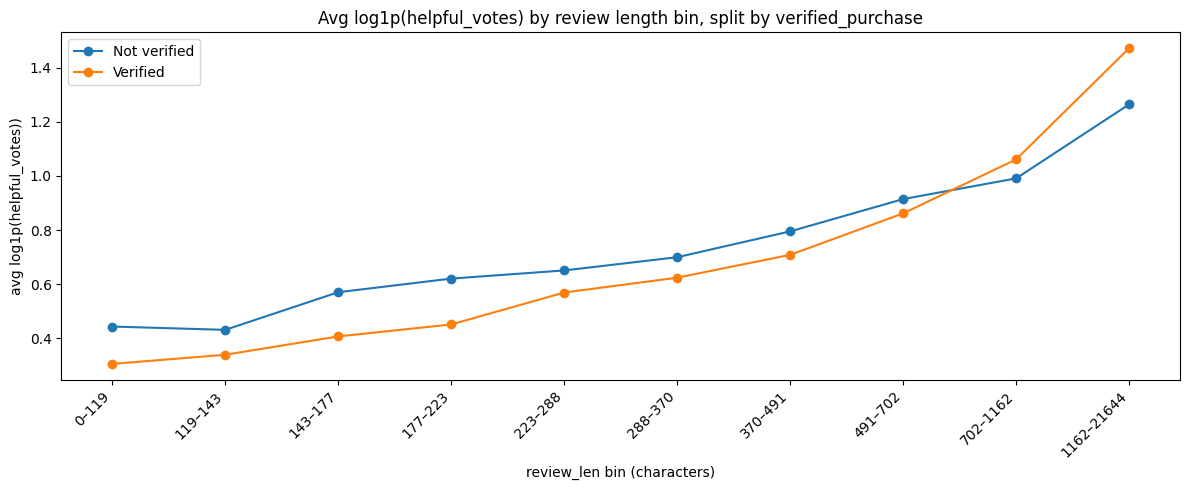

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


d = df_plot.dropna(subset=["helpful_votes", "verified_purchase", "review_len"]).copy()
d["helpful_log1p"] = np.log1p(d["helpful_votes"].astype(int))

d["len_bin"] = pd.qcut(d["review_len"], q=10, duplicates="drop")

summary = (
    d.groupby(["len_bin", "verified_purchase"])
     .agg(mean_helpful_log1p=("helpful_log1p", "mean"),
          n=("helpful_log1p", "size"))
     .reset_index()
)

pivot_mean = summary.pivot(index="len_bin", columns="verified_purchase", values="mean_helpful_log1p")
pivot_n = summary.pivot(index="len_bin", columns="verified_purchase", values="n")

x_labels = [f"{int(b.left)}–{int(b.right)}" for b in pivot_mean.index]
x = np.arange(len(x_labels))

plt.figure(figsize=(12,5))
plt.plot(x, pivot_mean.get(False), marker="o", label="Not verified")
plt.plot(x, pivot_mean.get(True), marker="o", label="Verified")

plt.title("Avg log1p(helpful_votes) by review length bin, split by verified_purchase")
plt.xlabel("review_len bin (characters)")
plt.ylabel("avg log1p(helpful_votes))")
plt.xticks(x, x_labels, rotation=45, ha="right")
plt.legend()
plt.tight_layout()
plt.show()




Looking further into the noise, we can see there is a positive relationship between length of review and average helpful votes.